Solving bike rebalancing using clustering + TSP approach...
Clustering + TSP solution completed in 0.06 seconds
Solving bike rebalancing linear program...
Linear programming solution completed in 507.12 seconds

=== SOLUTION EVALUATION ===

Linear Programming Solution:
- Total distance: 0.0000
- Computation time: 507.12 seconds
- Stations serviced: 64
- Bikes moved: 233.0

Clustering + TSP Solution:
- Total distance: 1.2657
- Computation time: 0.06 seconds
- Stations serviced: 133
- Vehicles used: 7

Comparison:
- Distance ratio (LP/CT): 0.00
- Time ratio (LP/CT): 8897.16
- Service difference (LP-CT): -69
- Recommended method: Linear Programming


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

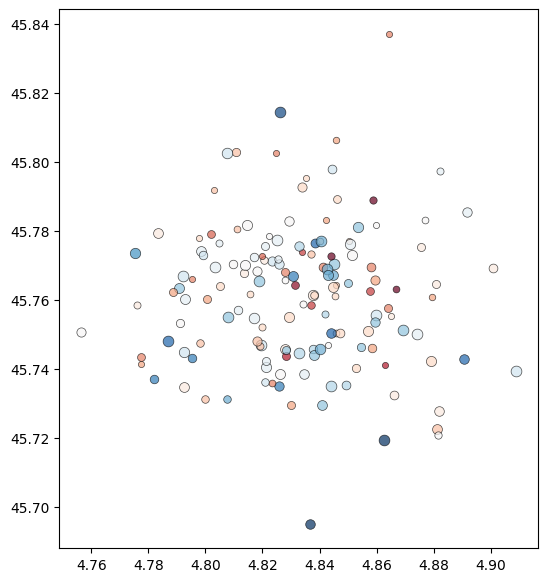

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import networkx as nx
from sklearn.cluster import KMeans
import pulp as pl
import time

class BikeRebalancingOptimizer:
    """
    A comprehensive bike-sharing rebalancing optimization framework that implements
    multiple mathematical models for bike redistribution in urban environments.
    """
    
    def __init__(self, stations_data=None):
        """
        Initialize the optimizer with station data or use simulated data.
        
        Parameters:
        -----------
        stations_data : pandas.DataFrame or None
            DataFrame containing station information with columns:
            - station_id: unique identifier
            - longitude: geographical coordinate
            - latitude: geographical coordinate
            - current_inventory: current number of bikes
            - target_inventory: desired number of bikes
        """
        self.stations = stations_data if stations_data is not None else self._generate_simulated_data()
        self.stations['imbalance'] = self.stations['current_inventory'] - self.stations['target_inventory']
        self.distance_matrix = None
        self.clusters = None
        self.routes = None
        self.rebalancing_plan = None
        
    def _generate_simulated_data(self, n_stations=150):
        """
        Generate simulated bike station data for Lyon.
        
        Parameters:
        -----------
        n_stations : int
            Number of stations to generate
            
        Returns:
        --------
        pandas.DataFrame
            Simulated station data
        """
        # Approximate coordinates for Lyon city center
        lyon_center = [4.835, 45.76]
        
        # Generate stations with a concentration around city center
        np.random.seed(42)  # For reproducibility
        longs = np.random.normal(lyon_center[0], 0.03, n_stations)
        lats = np.random.normal(lyon_center[1], 0.02, n_stations)
        
        # Generate inventory values with a realistic distribution
        current_inventory = np.random.randint(0, 20, n_stations)
        
        # Target inventory with some correlation to current inventory but with intentional imbalances
        noise = np.random.normal(0, 5, n_stations)
        target_inventory = np.maximum(0, np.minimum(20, current_inventory + noise))
        target_inventory = np.round(target_inventory).astype(int)
        
        # Create DataFrame
        return pd.DataFrame({
            'station_id': range(1, n_stations + 1),
            'longitude': longs,
            'latitude': lats,
            'current_inventory': current_inventory,
            'target_inventory': target_inventory
        })
    
    def compute_distance_matrix(self):
        """
        Compute the Euclidean distance matrix between all stations.
        """
        n = len(self.stations)
        self.distance_matrix = np.zeros((n, n))
        
        # Extract coordinates
        coords = self.stations[['longitude', 'latitude']].values
        
        # Compute pairwise Euclidean distances
        for i in range(n):
            for j in range(n):
                if i != j:
                    self.distance_matrix[i, j] = np.sqrt(
                        (coords[i, 0] - coords[j, 0])**2 + 
                        (coords[i, 1] - coords[j, 1])**2
                    )
                else:
                    self.distance_matrix[i, j] = 0
        
        return self.distance_matrix
    
    def cluster_stations(self, n_clusters=8):
        """
        Cluster stations geographically using K-means.
        
        Parameters:
        -----------
        n_clusters : int
            Number of clusters to create
        """
        # Extract coordinates for clustering
        coordinates = self.stations[['longitude', 'latitude']].values
        
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.stations['cluster'] = kmeans.fit_predict(coordinates)
        
        # Store cluster centers
        self.cluster_centers = kmeans.cluster_centers_
        
        return self.stations
    
    def solve_linear_program(self, cost_per_km=1.0, vehicle_capacity=20):
        """
        Solve the bike rebalancing problem using linear programming.
        
        Mathematical formulation:
        Minimize: Σᵢ Σⱼ cᵢⱼ * xᵢⱼ
        Subject to:
        - Flow conservation: Σⱼ xᵢⱼ - Σⱼ xⱼᵢ = bᵢ for all i
        - Vehicle capacity constraints
        - Pickup/dropoff constraints aligned with imbalance values
        
        Parameters:
        -----------
        cost_per_km : float
            Cost coefficient per kilometer traveled
        vehicle_capacity : int
            Maximum number of bikes a vehicle can carry
            
        Returns:
        --------
        dict
            Rebalancing plan with routes and bike movements
        """
        print("Solving bike rebalancing linear program...")
        start_time = time.time()
        
        # Make sure distance matrix is computed
        if self.distance_matrix is None:
            self.compute_distance_matrix()
        
        # Create a new PuLP model
        model = pl.LpProblem("BikeRebalancing", pl.LpMinimize)
        
        n = len(self.stations)
        station_ids = self.stations['station_id'].values
        imbalances = self.stations['imbalance'].values
        
        # Create decision variables
        # x[i,j,v] = 1 if vehicle v travels from station i to j, 0 otherwise
        x = {}
        for i in range(n):
            for j in range(n):
                if i != j:  # No self-loops
                    x[i,j] = pl.LpVariable(f"x_{i}_{j}", 0, 1, pl.LpBinary)
        
        # y[i] = number of bikes picked up (positive) or dropped off (negative) at station i
        y = {}
        for i in range(n):
            # Upper bound is either the station's surplus or vehicle capacity
            upper_bound = min(max(0, imbalances[i]), vehicle_capacity)
            # Lower bound is either the station's deficit or -vehicle_capacity
            lower_bound = max(min(0, imbalances[i]), -vehicle_capacity)
            y[i] = pl.LpVariable(f"y_{i}", lower_bound, upper_bound, pl.LpInteger)
        
        # load[i,j] = number of bikes in the vehicle when traveling from i to j
        load = {}
        for i in range(n):
            for j in range(n):
                if i != j:
                    load[i,j] = pl.LpVariable(f"load_{i}_{j}", 0, vehicle_capacity, pl.LpInteger)
        
        # Objective: Minimize total distance traveled
        model += pl.lpSum(self.distance_matrix[i,j] * cost_per_km * x[i,j] for i in range(n) for j in range(n) if i != j)
        
        # Constraints
        
        # 1. Flow conservation: each station is visited at most once
        for j in range(n):
            model += pl.lpSum(x[i,j] for i in range(n) if i != j) <= 1
            
        for i in range(n):
            model += pl.lpSum(x[i,j] for j in range(n) if i != j) <= 1
        
        # 2. Bike pickup/dropoff should respect imbalances
        for i in range(n):
            if imbalances[i] > 0:  # Surplus station
                model += y[i] <= imbalances[i]  # Can't pick up more than surplus
                model += y[i] >= 0  # Can only pick up from surplus stations
            elif imbalances[i] < 0:  # Deficit station
                model += y[i] >= imbalances[i]  # Can't drop off more than deficit
                model += y[i] <= 0  # Can only drop off at deficit stations
            else:  # Balanced station
                model += y[i] == 0  # No pickups or dropoffs at balanced stations
        
        # 3. Load constraints: tracking bikes in vehicle
        # If traveling from i to j, the load should change by the number of bikes picked up or dropped off
        for i in range(n):
            for j in range(n):
                if i != j:
                    # Load when leaving j equals load when arriving at j plus pickup/dropoff at j
                    for k in range(n):
                        if j != k and i != k:
                            model += load[j,k] - load[i,j] >= y[j] - vehicle_capacity * (1 - x[i,j]) - vehicle_capacity * (1 - x[j,k])
                            model += load[j,k] - load[i,j] <= y[j] + vehicle_capacity * (1 - x[i,j]) + vehicle_capacity * (1 - x[j,k])
        
        # 4. Vehicle capacity constraints
        for i in range(n):
            for j in range(n):
                if i != j:
                    model += load[i,j] <= vehicle_capacity
                    model += load[i,j] >= 0
        
        # 5. Subtour elimination constraints using Miller-Tucker-Zemlin formulation
        u = {}
        for i in range(1, n):
            u[i] = pl.LpVariable(f"u_{i}", 0, n-1, pl.LpInteger)
            
        for i in range(1, n):
            for j in range(1, n):
                if i != j:
                    model += u[i] - u[j] + n * x[i,j] <= n - 1
        
        # Solve the model
        model.solve(pl.PULP_CBC_CMD(msg=False))
        
        # Extract solution
        rebalancing_plan = {
            'status': pl.LpStatus[model.status],
            'objective_value': pl.value(model.objective),
            'routes': [],
            'pickups_dropoffs': {},
            'computation_time': time.time() - start_time
        }
        
        if model.status == pl.LpStatusOptimal:
            # Extract routes
            for i in range(n):
                for j in range(n):
                    if i != j and pl.value(x[i,j]) > 0.5:  # Binary variable is 1
                        rebalancing_plan['routes'].append((i, j))
            
            # Extract pickup/dropoff quantities
            for i in range(n):
                if pl.value(y[i]) != 0:
                    rebalancing_plan['pickups_dropoffs'][i] = pl.value(y[i])
        
        self.rebalancing_plan = rebalancing_plan
        print(f"Linear programming solution completed in {rebalancing_plan['computation_time']:.2f} seconds")
        
        return rebalancing_plan
    
    def solve_clustering_tsp(self, n_clusters=8):
        """
        Solve the rebalancing problem using a two-step approach:
        1. Cluster stations geographically
        2. Solve TSP within each cluster
        
        Parameters:
        -----------
        n_clusters : int
            Number of clusters (vehicles)
            
        Returns:
        --------
        dict
            Rebalancing plan with routes per cluster
        """
        print("Solving bike rebalancing using clustering + TSP approach...")
        start_time = time.time()
        
        # 1. Cluster stations if not already done
        if 'cluster' not in self.stations.columns:
            self.cluster_stations(n_clusters=n_clusters)
        
        # 2. Identify stations needing rebalancing
        rebalancing_stations = self.stations[self.stations['imbalance'] != 0].copy()
        
        # 3. Compute distance matrix if not already done
        if self.distance_matrix is None:
            self.compute_distance_matrix()
        
        # 4. Solve TSP within each cluster
        routes_by_cluster = {}
        
        for cluster_id in range(n_clusters):
            cluster_stations = rebalancing_stations[rebalancing_stations['cluster'] == cluster_id]
            
            if len(cluster_stations) <= 1:
                continue  # Skip clusters with 0-1 stations
                
            # Get indices of stations in this cluster
            station_indices = cluster_stations.index.tolist()
            
            # Create a subgraph for this cluster
            G = nx.DiGraph()
            
            # Add nodes
            for idx in station_indices:
                G.add_node(idx)
            
            # Add edges with distances as weights
            for i, idx1 in enumerate(station_indices):
                for j, idx2 in enumerate(station_indices):
                    if idx1 != idx2:
                        # Map to original index in distance matrix
                        orig_idx1 = self.stations.index.get_loc(idx1)
                        orig_idx2 = self.stations.index.get_loc(idx2)
                        
                        G.add_edge(idx1, idx2, weight=self.distance_matrix[orig_idx1, orig_idx2])
            
            # Solve TSP for this cluster using a simple approximation algorithm
            if len(G.nodes) >= 2:
                # Use nearest neighbor algorithm to approximate TSP
                path = [station_indices[0]]  # Start with first station
                unvisited = set(station_indices[1:])
                
                while unvisited:
                    last = path[-1]
                    # Find nearest unvisited station
                    next_station = min(unvisited, 
                                     key=lambda node: G[last][node]['weight'])
                    path.append(next_station)
                    unvisited.remove(next_station)
                
                # Complete the circuit
                path.append(path[0])
                
                # Store the route
                routes_by_cluster[cluster_id] = {
                    'path': path,
                    'stations': cluster_stations,
                    'distance': sum(G[path[i]][path[i+1]]['weight'] 
                                  for i in range(len(path)-1))
                }
        
        # 5. Prepare result
        clustering_tsp_result = {
            'status': 'Optimal',
            'routes_by_cluster': routes_by_cluster,
            'total_distance': sum(route_info['distance'] 
                                for route_info in routes_by_cluster.values()),
            'computation_time': time.time() - start_time
        }
        
        self.routes = clustering_tsp_result
        print(f"Clustering + TSP solution completed in {clustering_tsp_result['computation_time']:.2f} seconds")
        
        return clustering_tsp_result
    
    def visualize_results(self, show_routes=True, include_lp_solution=True):
        """
        Visualize rebalancing results with multiple panels.
        
        Parameters:
        -----------
        show_routes : bool
            Whether to show routes on the map
        include_lp_solution : bool
            Whether to include linear programming solution visualization
        """
        n_panels = 3 if include_lp_solution else 2
        
        plt.figure(figsize=(7*n_panels, 7))
        
        # Panel 1: Station Distribution
        plt.subplot(1, n_panels, 1)
        
        # Color map based on imbalance
        norm = plt.Normalize(vmin=-10, vmax=10)
        cmap = plt.cm.RdBu_r  # Red-Blue colormap
        
        # Plot stations with size based on target inventory and color based on imbalance
        for idx, station in self.stations.iterrows():
            size = 20 + station['target_inventory'] * 2
            color = cmap(norm(station['imbalance']))
            plt.scatter(station['longitude'], station['latitude'], 
                       s=size, c=[color], alpha=0.7, 
                       edgecolors='k', linewidths=0.5)
        
        # Create a new axis for the colorbar
        cax = plt.gca().inset_axes([1.05, 0.1, 0.03, 0.8])
        plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), 
                   label='Imbalance (Surplus/Deficit)', cax=cax)
        plt.title('(a) Station Target Distribution')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        
        # Panel 2: Clustering + TSP Solution
        if self.routes is not None:
            plt.subplot(1, n_panels, 2)
            
            # Plot clusters with different colors
            colors = plt.cm.tab10.colors
            
            # Plot all stations as background
            plt.scatter(self.stations['longitude'], self.stations['latitude'], 
                      s=10, c='lightgray', alpha=0.3)
            
            # Plot routes by cluster
            for cluster_id, route_info in self.routes['routes_by_cluster'].items():
                color = colors[cluster_id % len(colors)]
                path = route_info['path']
                
                # Plot route
                for i in range(len(path) - 1):
                    idx1 = path[i]
                    idx2 = path[i + 1]
                    
                    x1 = self.stations.loc[idx1, 'longitude']
                    y1 = self.stations.loc[idx1, 'latitude']
                    x2 = self.stations.loc[idx2, 'longitude']
                    y2 = self.stations.loc[idx2, 'latitude']
                    
                    plt.plot([x1, x2], [y1, y2], c=color, linewidth=1.5, alpha=0.7)
                
                # Plot stations in this cluster's route
                for idx in path[:-1]:  # Exclude last point (repeat of first)
                    station = self.stations.loc[idx]
                    marker = 'o' if station['imbalance'] > 0 else 's'
                    plt.scatter(station['longitude'], station['latitude'], 
                              s=80, c=[color], marker=marker,
                              edgecolors='k', linewidths=1)
            
            plt.title('(b) Clustering + TSP Solution')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
        
        # Panel 3: Linear Programming Solution
        if include_lp_solution and self.rebalancing_plan is not None:
            plt.subplot(1, n_panels, 3)
            
            # Plot all stations as background
            plt.scatter(self.stations['longitude'], self.stations['latitude'], 
                      s=10, c='lightgray', alpha=0.3)
            
            # Plot routes from LP solution
            if 'routes' in self.rebalancing_plan:
                # Use a different color scheme
                cmap = plt.cm.viridis
                
                # Group routes into connected components to assign colors
                G = nx.DiGraph()
                for i, j in self.rebalancing_plan['routes']:
                    G.add_edge(i, j)
                
                # Find connected components (vehicle routes)
                components = list(nx.weakly_connected_components(G))
                
                # Assign colors to components
                for k, component in enumerate(components):
                    color = cmap(k / max(1, len(components) - 1))
                    
                    # Extract edges in this component
                    component_edges = [(i, j) for i, j in self.rebalancing_plan['routes'] 
                                     if i in component or j in component]
                    
                    # Plot edges
                    for i, j in component_edges:
                        x1 = self.stations.iloc[i]['longitude']
                        y1 = self.stations.iloc[i]['latitude']
                        x2 = self.stations.iloc[j]['longitude']
                        y2 = self.stations.iloc[j]['latitude']
                        
                        plt.plot([x1, x2], [y1, y2], c=color, linewidth=1.5, alpha=0.7)
                
                # Plot pickup/dropoff stations
                for i, quantity in self.rebalancing_plan['pickups_dropoffs'].items():
                    station = self.stations.iloc[i]
                    marker = 'o' if quantity > 0 else 's'  # Circle for pickup, square for dropoff
                    size = 50 + abs(quantity) * 10
                    
                    plt.scatter(station['longitude'], station['latitude'], 
                              s=size, c='none', marker=marker,
                              edgecolors='red' if quantity > 0 else 'blue', 
                              linewidths=2)
            
            plt.title('(c) Linear Programming Solution')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
        
        plt.tight_layout()
        plt.suptitle('Bike-Sharing Rebalancing Optimization', fontsize=16, y=1.05)
        
        return plt

    def evaluate_solutions(self):
        """
        Compare and evaluate different optimization approaches.
        
        Returns:
        --------
        dict
            Comparative evaluation metrics
        """
        evaluation = {
            'metrics': {},
            'comparison': {}
        }
        
        # Extract metrics from linear programming solution
        if self.rebalancing_plan is not None:
            lp_metrics = {
                'total_distance': self.rebalancing_plan['objective_value'],
                'computation_time': self.rebalancing_plan['computation_time'],
                'stations_serviced': len(self.rebalancing_plan['pickups_dropoffs']),
                'bikes_moved': sum(abs(qty) for qty in self.rebalancing_plan['pickups_dropoffs'].values()),
                'solution_method': 'Linear Programming'
            }
            evaluation['metrics']['lp'] = lp_metrics
        
        # Extract metrics from clustering + TSP solution
        if self.routes is not None:
            ct_metrics = {
                'total_distance': self.routes['total_distance'],
                'computation_time': self.routes['computation_time'],
                'stations_serviced': sum(len(route_info['path']) - 1  # -1 because first station is repeated at end
                                       for route_info in self.routes['routes_by_cluster'].values()),
                'vehicles_used': len(self.routes['routes_by_cluster']),
                'solution_method': 'Clustering + TSP'
            }
            evaluation['metrics']['clustering_tsp'] = ct_metrics
        
        # Compare solutions if both methods were used
        if self.rebalancing_plan is not None and self.routes is not None:
            evaluation['comparison'] = {
                'distance_ratio': lp_metrics['total_distance'] / ct_metrics['total_distance'],
                'time_ratio': lp_metrics['computation_time'] / ct_metrics['computation_time'],
                'service_difference': lp_metrics['stations_serviced'] - ct_metrics['stations_serviced'],
                'recommended_method': 'Linear Programming' 
                    if lp_metrics['total_distance'] < ct_metrics['total_distance'] 
                    else 'Clustering + TSP'
            }
        
        return evaluation

# Example usage
def run_bike_rebalancing_optimization():
    # Initialize optimizer with simulated data
    optimizer = BikeRebalancingOptimizer()
    
    # Solve using clustering + TSP approach
    tsp_solution = optimizer.solve_clustering_tsp(n_clusters=8)
    
    # Solve using linear programming approach
    lp_solution = optimizer.solve_linear_program(cost_per_km=1.0, vehicle_capacity=20)
    
    # Evaluate solutions
    evaluation = optimizer.evaluate_solutions()
    
    # Display evaluation results
    print("\n=== SOLUTION EVALUATION ===")
    
    # Linear Programming results
    lp = evaluation['metrics']['lp']
    print("\nLinear Programming Solution:")
    print(f"- Total distance: {lp['total_distance']:.4f}")
    print(f"- Computation time: {lp['computation_time']:.2f} seconds")
    print(f"- Stations serviced: {lp['stations_serviced']}")
    print(f"- Bikes moved: {lp['bikes_moved']}")
    
    # Clustering + TSP results
    ct = evaluation['metrics']['clustering_tsp']
    print("\nClustering + TSP Solution:")
    print(f"- Total distance: {ct['total_distance']:.4f}")
    print(f"- Computation time: {ct['computation_time']:.2f} seconds")
    print(f"- Stations serviced: {ct['stations_serviced']}")
    print(f"- Vehicles used: {ct['vehicles_used']}")
    
    # Comparison
    comparison = evaluation['comparison']
    print("\nComparison:")
    print(f"- Distance ratio (LP/CT): {comparison['distance_ratio']:.2f}")
    print(f"- Time ratio (LP/CT): {comparison['time_ratio']:.2f}")
    print(f"- Service difference (LP-CT): {comparison['service_difference']}")
    print(f"- Recommended method: {comparison['recommended_method']}")
    
    # Visualize results
    plt = optimizer.visualize_results(show_routes=True, include_lp_solution=True)
    plt.savefig('bike_rebalancing_optimization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return optimizer, evaluation

if __name__ == "__main__":
    optimizer, evaluation = run_bike_rebalancing_optimization()

In [6]:
pip install pulp

   ---------------------------------------- 0.0/17.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.7 MB 445.2 kB/s eta 0:00:40
   ---------------------------------------- 0.1/17.7 MB 991.0 kB/s eta 0:00:18
    --------------------------------------- 0.4/17.7 MB 2.4 MB/s eta 0:00:08
   -- ------------------------------------- 1.3/17.7 MB 6.3 MB/s eta 0:00:03
   ----- ---------------------------------- 2.6/17.7 MB 10.2 MB/s eta 0:00:02
   ------ --------------------------------- 2.9/17.7 MB 11.1 MB/s eta 0:00:02
   ------- -------------------------------- 3.4/17.7 MB 9.9 MB/s eta 0:00:02
   ----------- ---------------------------- 5.1/17.7 MB 13.2 MB/s eta 0:00:01
   ----------- ---------------------------- 5.3/17.7 MB 13.5 MB/s eta 0:00:01
   ----------- ---------------------------- 5.3/17.7 MB 13.5 MB/s eta 0:00:01
   ---------------- ----------------------- 7.2/17.7 MB 13.5 MB/s eta 0:00:01
   


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
